In [1]:
import numpy as np
import ufl
from mpi4py import MPI
from dolfinx import mesh, fem
from dolfinx.fem.petsc import LinearProblem
from dolfinx.geometry import compute_collisions_points
from dolfinx.geometry import compute_colliding_cells
from dolfinx.geometry import bb_tree
import matplotlib.pyplot as plt
from petsc4py import PETSc

In [2]:
# Create 1D mesh
domain = mesh.create_interval(MPI.COMM_WORLD, 20, [0.0, 1.0])

# Define function space
V = fem.FunctionSpace(domain, ("Lagrange", 1))

In [3]:
# Define Dirichlet BC: u = 0 at both ends
# u_D = fem.Constant(domain, PETSc.ScalarType(0.0))
# Crée une Function constante sur l’espace V, au lieu d’un Constant global
u_D = fem.Function(V)
u_D.x.array[:] = 0.0  # Valeur imposée sur les bords
def boundary(x):
    return np.isclose(x[0], 0.0) | np.isclose(x[0], 1.0)
facets = mesh.locate_entities_boundary(domain, dim=0, marker=boundary)
bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, 0, facets))

In [4]:
# Define variational problem
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(1.0))
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

In [5]:
# Solve
uh = fem.Function(V)
problem = LinearProblem(a, L, bcs=[bc], u=uh)
problem.solve()

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, interval, 1, gll_warped, unset, False), (1,)), 0), Basix element (P, interval, 1, gll_warped, unset, False)), 1)

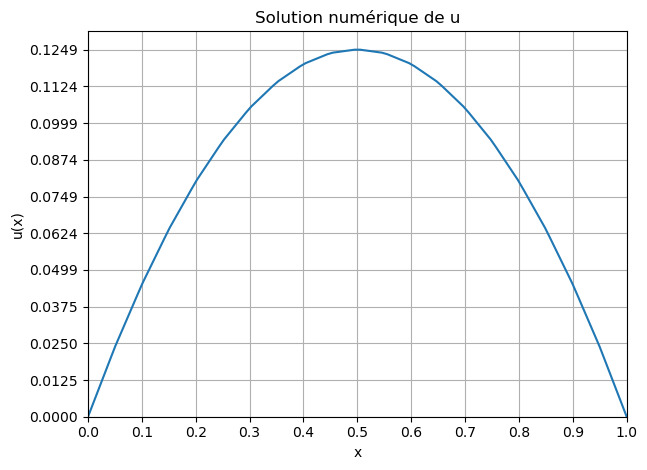

In [20]:
# Grille de points d’évaluation
x_vals = np.linspace(0, 1, 100).reshape(-1, 1)
x_pts = np.zeros((len(x_vals), 3), dtype=np.float64)
x_pts[:, 0] = x_vals[:, 0]

# Créer le bounding box tree
tree = bb_tree(domain, domain.topology.dim)

# Étape 1 : candidats via bounding box
candidates = compute_collisions_points(tree, x_pts)

# Étape 2 : cellules effectivement collidantes
colliding = compute_colliding_cells(domain, candidates, x_pts)

cells = []
for i, pt in enumerate(x_pts):
    # colliding.links(i) donne la liste des cellules collidantes pour le point i
    cell_links = colliding.links(i)
    if len(cell_links) > 0:
        cells.append(cell_links[0])
    else:
        cells.append(-1)

# Puis évaluation
u_vals = np.array([uh.eval(pt, cell) if cell != -1 else np.nan for pt, cell in zip(x_pts, cells)])
# Plot only on rank 0
if MPI.COMM_WORLD.rank == 0:
    plt.plot(x_vals, u_vals)
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.title("Solution numérique de u")
    plt.grid(True)
    plt.xlim(0, 1)
    plt.ylim(np.nanmin(u_vals)*1.05, np.nanmax(u_vals)*1.05)
    plt.tight_layout()
    plt.xticks(np.linspace(0, 1, 11))
    plt.yticks(np.linspace(np.nanmin(u_vals), np.nanmax(u_vals), 11))
    plt.tick_params(axis='both', which='both', labelsize=10)
    plt.show()